<a href="https://colab.research.google.com/github/pejmanrasti/EPU_ML_Angers_2023/blob/main/Jour_2/EPU_5_ExempleRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import warnings
import math

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV,RepeatedStratifiedKFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import make_scorer, roc_auc_score,precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import  RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import pandas as pd
from pandas import read_csv

import numpy as np
from numpy import arange
from numpy import mean
from numpy import std
from numpy import percentile

from matplotlib import pyplot as plt

from imblearn.under_sampling import RandomUnderSampler



# Mesures de performances en régression
Pour les tâches de régression, on cherche à mesure la distance entre les valeurs prédites et les valeurs réelles.
* RMSE : Root mean square error ou erreur quadratique moyenne. Comme son nom l'indique c'est la racine carrée de l'erreur quadratique moyenne.
$$
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n (y_{pred}^i - y_{vrai}^i)^2}
$$
n est le nombre d'observations dans le jeu de données, $y_{pred}$ les cibles prédites et $y_{vrai}$ les cibles réelles.
* MAE : Mean absolute error ou erreur absolue moyenne.
$$
MAE = {\frac{1}{n}\sum_{i=1}^n \left\lvert{y_{pred}^i - y_{vrai}^i}\right\lvert}
$$

* RMSE est plus sensible aux valeurs s'écartant de la normale (queue de distribution). Pour la prédiction des GPR hors tolérance, on aura tendance à préférer la RMSE comme mesure de performance.

#Import et séparation des données

In [ ]:
df = read_csv("/content/DataSet_RegionPelvienne_Reg.csv", sep = ",", header=0)
df = df.drop(columns = ["Unnamed: 0"])

y = df['Gamma22loc10']
z = df.drop('Gamma22loc10', axis = 1)

#On met de côté les données test qui seront utilisées à la fin
X_train, X_test, Y_train, Y_test = train_test_split(z,y, test_size = 0.3, random_state=2023)


# Entrainement du modèle

In [ ]:
%%time

#Paramètre de la recherche sur grille pour l'algorithme random forest regressor de scikit
params = {
    'bootstrap': [True, False],
    'n_estimators': [5, 50, 100],
    'max_depth': [None, 6, 8, 10, 12]
    }

reg = RandomForestRegressor(random_state=2023)

# Sur la CV, scikit utilise l'opposée de la RMSE car il préfère optimiser les scores vers le haut plutôt que vers le bas.
recherche = GridSearchCV(reg,
                           params,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=False)
recherche.fit(X_train, Y_train)



CPU times: user 4min 8s, sys: 200 ms, total: 4min 8s
Wall time: 4min 9s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=2023),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 6, 8, 10, 12],
                         'n_estimators': [5, 50, 100]},
             scoring='neg_root_mean_squared_error')

In [ ]:
#On affiche les meilleurs hyper-paramètres
recherche.best_params_

{'bootstrap': True, 'max_depth': 10, 'n_estimators': 50}

In [ ]:
# Le régresseur issu de la CV
recherche.best_estimator_

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=2023)

In [ ]:
#Prédiction des données test
Y_test_pred = recherche.best_estimator_.predict(X_test)

# Evaluation des résultats

In [ ]:
rmse_valid_mean = recherche.cv_results_['mean_test_score'][recherche.best_index_]
rmse_valid_std = recherche.cv_results_['std_test_score'][recherche.best_index_]
print("l'erreur quadratique moyenne de prédiction des GPR sur les données de validation est de l'ordre de ", round(-rmse_valid_mean, 2), "% +- ",round(rmse_valid_std, 2), "%" )

#mean_squared_error() retourne la MSE si l'option squared est True et la RMSE si l'option squared est False
rmse_test = metrics.mean_squared_error(Y_test, Y_test_pred, squared = False)
print("l'erreur quadratique moyenne de prédiction des GPR sur les données test est de l'ordre de ", round(rmse_test, 2), "%")

l'erreur quadratique moyenne de prédiction des GPR sur les données de validation est de l'ordre de  0.58 % +-  0.06 %
l'erreur quadratique moyenne de prédiction des GPR sur les données test est de l'ordre de  0.53 %


In [ ]:
max_error_test = metrics.max_error(Y_test, Y_test_pred)
print("l'erreur max de prédiction des GPR sur les données test est de l'ordre de ", round(max_error_test, 2), "%")

l'erreur max de prédiction des GPR sur les données test est de l'ordre de  3.44 %


In [ ]:
mean_abs_error_test = metrics.mean_absolute_error(Y_test, Y_test_pred)
print("l'erreur moyenne absolue de prédiction des GPR sur les données test est de l'ordre de ", round(mean_abs_error_test, 2), "%")

l'erreur moyenne absolue de prédiction des GPR sur les données test est de l'ordre de  0.37 %


In [ ]:
# Ecart type des données test
np.std(Y_test)

0.671146593524843

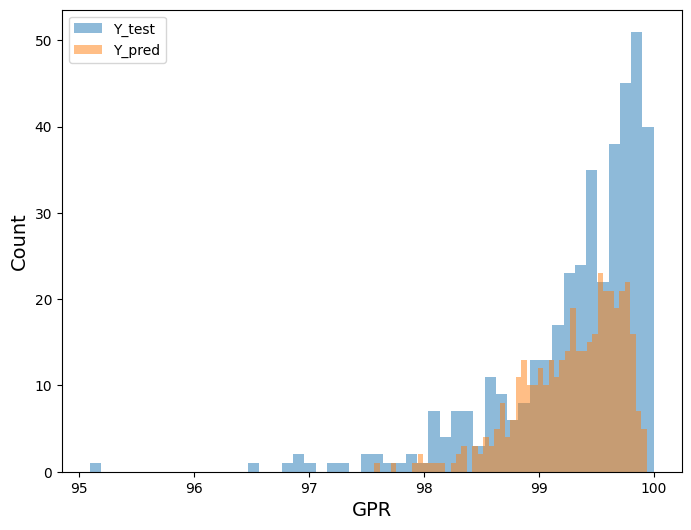

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(np.array(Y_test), bins=50, alpha=0.5, label="Y_test")
plt.hist(Y_test_pred, bins=50, alpha=0.5, label="Y_pred")
plt.xlabel("GPR", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper left')